In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Imports and setting up environment
!pip install pycm livelossplot torchvision -q
%pylab inline

from PIL import Image
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, RandomHorizontalFlip, RandomAffine, ToPILImage, Resize

from livelossplot import PlotLosses
from pycm import *

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import random

# this is the same function from the lecture; included here to easily set the seed for random functions
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  #uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled  = False

    return True

# set the device to GPU if available:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")    

Populating the interactive namespace from numpy and matplotlib
Cuda installed! Running on GPU!


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random', 'Normalize']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
# Download the data 
!sudo apt-get update -q
!sudo apt-get install wget -q
!wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1AL0Rh5mjPgQH3pKrWqJlxVcbuAgXbON7' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1AL0Rh5mjPgQH3pKrWqJlxVcbuAgXbON7" -O data.zip && rm -rf /tmp/cookies.txt
from zipfile import ZipFile
with ZipFile('./data.zip', 'r') as zipObj:
    print("Started unzipping... \n")
    # Extract all the contents of zip file in current directory
    zipObj.extractall()
    print("Files unziped sucessfully\n")
!ls

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:9 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Reading package lists...
Reading package lists...
Building dependency tree...
Reading state information...
wget is already the newest

In [0]:
# Load our path
import os
path = './'
os.listdir(path)

['.config',
 'data.zip',
 'drive',
 'train',
 'mapping.py',
 '__MACOSX',
 'mapping.json',
 'test',
 'sample_data']

In [0]:
# CNN Parameters
weight_decay = 0
seed = 42
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 500
n_epochs = 3

In [0]:
# Create DataSets and DataLoader

train_transform = Compose([
    # RandomHorizontalFlip(),
    # RandomRotation(10),
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_train_transform = Compose([
    # RandomHorizontalFlip(),
    # RandomRotation(10),
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_set = ImageFolder(path+'train', transform=train_transform)
full_train_set = ImageFolder(path+'train', transform=train_transform)
test_set = ImageFolder(path+'test', transform=test_transform)

# For full training
full_train_loader = DataLoader(full_train_set, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False, num_workers=0)

In [0]:
# Split training and validation sets
train_data, val_data = torch.utils.data.random_split(train_set, [90000, 10000])

batch_size = 64
test_batch_size = 500

# DataLoader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_data, batch_size=test_batch_size, shuffle=False, num_workers=0)

# check length, should be 1407, 20
print(len(train_loader),len(val_loader))

1407 20


In [0]:
# Functions for resnet-18 training, validating and evaluating
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 3, 224, 224))   # image size now 224
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()      
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 224, 224))   
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)
  
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    i = 0
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 224, 224))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

In [0]:
# Initialize model_rn
set_seed(seed)
model_rn = models.wide_resnet101_2(pretrained=True).cuda() # use pretrained since ImageNet is relevant to this dataset
num_fils = model_rn.fc.in_features
model_rn.fc = nn.Sequential(
            # nn.Dropout(),
            nn.Linear(num_fils, 200)).cuda()  # modify output to 200 classes
model_rn = nn.DataParallel(model_rn)
print("model finish")

Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to /root/.cache/torch/checkpoints/wide_resnet101_2-32ee1156.pth



model finish


In [0]:
# decide to train all parameters because from coursework, this will give much higher accuracy
optimizer = torch.optim.SGD(model_rn.parameters() , lr=lr, momentum=momentum, weight_decay=0) 
criterion = nn.CrossEntropyLoss()
liveloss = PlotLosses()

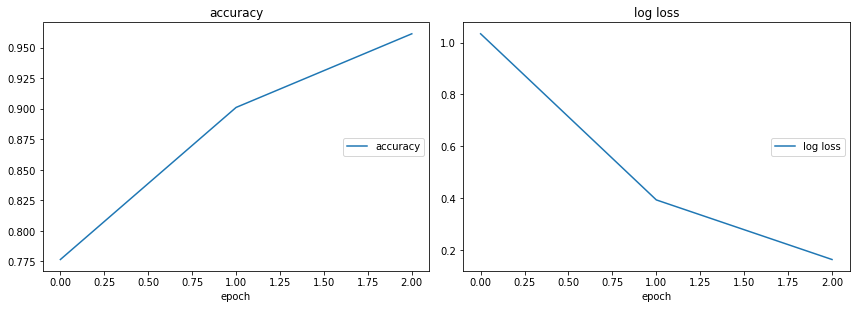

accuracy
	accuracy         	 (min:    0.777, max:    0.961, cur:    0.961)
log loss
	log loss         	 (min:    0.165, max:    1.034, cur:    0.165)


In [0]:
# Train resnet model
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model_rn, optimizer, criterion, full_train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    
    liveloss.update(logs)
    liveloss.draw()
    
    logs['val_' + 'log loss'] = 0.
    logs['val_' + 'accuracy'] = 0.

In [0]:
# Save model
torch.save(model_rn.state_dict(), "./resnet101.pth")

In [0]:
# Evaluate final model on test data
test_set = ImageFolder(path+'test', transform=test_transform)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)
y_pred, y_gt = evaluate(model_rn, test_loader)

In [0]:
# Clean and store submission
out = np.array([y_pred])
import pandas as pd
output = pd.DataFrame(out.T, columns=['Label'])
output.insert(0, 'Filename', 'test_'+output.index.astype(str)+'.jpeg')
output.to_csv('submission.csv', index=False)

In [0]:
# Check submission is in correct format
output.head()

,Filename,Label
0,test_0.jpeg,107
1,test_1.jpeg,168
2,test_2.jpeg,158
3,test_3.jpeg,90
4,test_4.jpeg,138


In [0]:
# Move model and submission file to Google Drive main folder
import shutil, sys                                                                                                                                                    
shutil.move("./submission.csv", "./drive/My Drive/") 
shutil.move("./resnet101.pth", "./drive/My Drive/") 

'./drive/My Drive/resnet101.pth'